# !!!!!!NOTE!!!!!
### we are going to use VXT now (Achtibat et al. 2024). See docs:
 https://github.com/rachtibat/LRP-eXplains-Transformers
 https://lxt.readthedocs.io/en/latest/quickstart.html

### rather than Chefer et al. 2021: https://arxiv.org/abs/2012.09838

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from einops import rearrange
from einops.layers.torch import Rearrange

import Simple_ViT.simple_vit as svit
import Simple_ViT.simple_vit_lrp as svitl

import importlib
# When you need to reload the module after an update
importlib.reload(svitl)

import getpass
myname = getpass.getuser()

import pandas as pd

import operator
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from lxt.core import Composite
import lxt.functional as lf
import lxt.modules as lm
import lxt.rules as rules

# import open_clip
# import open_clip.transformer
from openclip_ViT import transformer
from PIL import Image
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules
from zennit.image import imgify

# Data and Compute Prep:

In [2]:
doDask = False
if doDask:
    print('...setting up dask client...')
    if 'client' in locals():
        client.shutdown()
        print('...shutdown client...')
    else:
        print('client does not exist yet')

    # ### ++++++ dask NCAR client: 
    from distributed import Client
    from dask_jobqueue import PBSCluster
    project_num = 'P03010039' #'P03010039' #what project key do you have? 
    
    cluster = PBSCluster(account=project_num,
                         walltime='12:00:00',
                         cores=1,
                         memory='40GB',
                         shared_temp_directory='/glade/derecho/scratch/kjmayer/tmp',
                         queue='casper')
    cluster.scale(jobs=40)
    client = Client(cluster)
    print(client) 

print(torch.cuda.is_available())

def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

True
device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
using device:  cuda


# LOAD & PREP DATA

## Load the Data

In [3]:
myname = 'kjmayer'
dirout = f'/glade/derecho/scratch/{myname}/TOMSensoDS/'
# Check if the directory exists
if not os.path.exists(dirout):
    # Create the directory
    os.makedirs(dirout)
    print(f"Directory {dirout} created.")
else:
    print(f"Directory {dirout} already exists.")

# Old files:
# DSmean_sst_anom = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI_Chunked.nc'))
# DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI_Chunked.nc'))
# DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'TREFHT_CESM2_PI_Chunked.nc'))
# DSmean_sst_anom['time'] = DSmean_trefht_anom_roll['time']

DSmean_sst_anom = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI_Chunked_Rolled.nc')) #30 day centered rolling mean
print('...done loading SST...')

DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI_Chunked_Rolled.nc')) #30 day centered rolling mean
print('...done loading TREFHT...')

if doDask: 
    DSmean_sst_anom = DSmean_sst_anom.chunk({'time':5})
    DSmean_trefht_anom_roll = DSmean_trefht_anom_roll.chunk({'time':5})
    DSmean_sst_anom = DSmean_sst_anom.chunk({'time':5})

Directory /glade/derecho/scratch/kjmayer/TOMSensoDS/ already exists.
...done loading SST...
...done loading TREFHT...


## Slice spatially and temporally

In [4]:
# NOTE: adding 30 because of 30 day rolling mean on X and Y
lead_time = 30 + 30 

# SUBSET X TO 5S-5N & SLICE FOR LEAD
DSmean_sst_anom_lag = DSmean_sst_anom['SST'].isel(time=slice(0,-lead_time),
                                                  lat=slice(90,102))

# SUBSET Y TO REGION (off coast of southern CA) & SLICE FOR LEAD
# (32-36N, 230-235E)
ilat, flat = 129, 135
ilon, flon = 184, 189
DSmean_trefht_anom_roll_lag = DSmean_trefht_anom_roll['SST'].isel(time=slice(lead_time,len(DSmean_trefht_anom_roll['time'])),
                                                                 lat=slice(ilat,flat),
                                                                 lon=slice(ilon,flon))
print(DSmean_trefht_anom_roll_lag.lat, DSmean_trefht_anom_roll_lag.lon)
# DSmean_trefht_anom_roll_lag = DSmean_trefht_anom_roll['TREHT'].isel(time=slice(lead_time,len(DSmean_trefht_anom_roll['time'])))

<xarray.DataArray 'lat' (lat: 6)>
array([31.570681, 32.513089, 33.455497, 34.397906, 35.340314, 36.282723])
Coordinates:
  * lat      (lat) float64 31.57 32.51 33.46 34.4 35.34 36.28
Attributes:
    long_name:  latitude
    units:      degrees_north <xarray.DataArray 'lon' (lon: 5)>
array([230.  , 231.25, 232.5 , 233.75, 235.  ])
Coordinates:
  * lon      (lon) float64 230.0 231.2 232.5 233.8 235.0
Attributes:
    long_name:  longitude
    units:      degrees_east


## Let's Lag this Bad Baby

In [5]:
%%time
print('here we go')
##################################################
##### 1700 - 2000
##################################################

date_range = pd.date_range(start='1700-01-01', end='2000-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
end_date_300 = len(filtered_date_range)

print('...gather training...')
y_train = DSmean_trefht_anom_roll_lag.isel(time=slice(0,end_date_300-1))
y_train_anom = y_train.groupby('time.dayofyear') - y_train.groupby('time.dayofyear').mean()
x_train = DSmean_sst_anom_lag.isel(time=slice(0,end_date_300-1))
x_train_anom = x_train.groupby('time.dayofyear') - x_train.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################
date_range = pd.date_range(start='1700-01-01', end='2101-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_val_s = int(np.where(filtered_date_range == '2000-01-01')[0])
indy_val_e = int(np.where(filtered_date_range == '2100-01-01')[0])

print('...gather validation...')
y_val = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_val_s,indy_val_e))
y_val_anom = y_val.groupby('time.dayofyear') - y_val.groupby('time.dayofyear').mean()
x_val = DSmean_sst_anom_lag.isel(time=slice(indy_val_s,indy_val_e))
x_val_anom = x_val.groupby('time.dayofyear') - x_val.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################

date_range = pd.date_range(start='1700-01-01', end='2201-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_test_s = int(np.where(filtered_date_range == '2100-01-01')[0])
indy_test_e = int(np.where(filtered_date_range == '2200-01-01')[0])

print('...gather testing...')
y_test = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_test_s,indy_test_e))
y_test_anom = y_test.groupby('time.dayofyear') - y_test.groupby('time.dayofyear').mean()
x_test = DSmean_sst_anom_lag.isel(time=slice(indy_test_s,indy_test_e))
x_test_anom = x_test.groupby('time.dayofyear') - x_test.groupby('time.dayofyear').mean()
print('done')

here we go
...gather training...


<timed exec>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


...gather validation...


<timed exec>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


...gather testing...
done
CPU times: user 14 s, sys: 15.5 s, total: 29.6 s
Wall time: 50.2 s


## Subset for DJF

In [6]:
ixtrain_DJF = np.where(x_train_anom['time.month'].isin([12,1,2]))[0]
ixval_DJF = np.where(x_val_anom['time.month'].isin([12,1,2]))[0]
ixtest_DJF = np.where(x_test_anom['time.month'].isin([12,1,2]))[0]

x_train_anom_DJF = x_train_anom[ixtrain_DJF]
x_val_anom_DJF = x_val_anom[ixval_DJF]
x_test_anom_DJF = x_test_anom[ixtest_DJF]

y_train_anom_DJF = y_train_anom[ixtrain_DJF]
y_val_anom_DJF = y_val_anom[ixval_DJF]
y_test_anom_DJF = y_test_anom[ixtest_DJF]

## Convert to numpy

In [7]:
%%time
np_arr_x_train_anom = np.array(x_train_anom_DJF)
np_arr_x_val_anom = np.array(x_val_anom_DJF) 
np_arr_y_train_anom = np.array(y_train_anom_DJF)
np_arr_y_val_anom = np.array(y_val_anom_DJF)

CPU times: user 30.7 ms, sys: 31.1 ms, total: 61.8 ms
Wall time: 81.9 ms


## look at ENSO and find Y region

In [16]:
%%time
# Find a good location to predict
# enso = x_train_anom_DJF.sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
# nino = enso.where(enso >= 2, drop=True).load()
# nina = enso.where(enso <= -2, drop=True).load()
# notenso = enso.where((enso > -2) & (enso < 2), drop=True).load()
# notnino = enso.where(enso < 2, drop=True).load()

# corrs = np.zeros(shape=(42,41))
# for ilat in np.arange(0,len(y_train_anom_DJF.lat)):
#     for ilon in np.arange(0,len(y_train_anom_DJF.lon)):
#         corrs[ilat,ilon] = np.corrcoef(enso,y_train_anom_DJF[:, ilat, ilon])[0,1]

# plt.pcolormesh(corrs,cmap='RdBu_r',vmin=-.5,vmax=.5)
# plt.colorbar()
# plt.show()

# Define & Check Predictand Point (do not delete this bad boy; vital for exsistence)
# enso = x_train_anom_DJF.sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
# inino = np.where(enso >= 2)[0]
# inina = np.where(enso <= -2)[0]
# inotenso = np.where((enso > -2) & (enso < 2))[0]

# change these and make sure the Y loading doesnt already subset to a region
# ilat, flat = 129, 135
# ilon, flon = 184, 189
# yall = y_train_anom_DJF[:, ilat:flat, ilon:flon].mean(('lat','lon')).isel(time=inotenso)
# ynino = y_train_anom_DJF[:, ilat:flat, ilon:flon].mean(('lat','lon')).isel(time=inino)

# plt.hist(yall,density=True,bins=50)
# plt.hist(ynino,density=True,alpha=0.5,bins=50)
# plt.show()

# plt.pcolormesh(np_arr_x_train_anom[0])
# plt.show()
# plt.pcolormesh(np_arr_y_train_anom[0])
# plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


# TRAINING

## Data Loader

In [8]:
class SpatialDataset(Dataset):
    def __init__(self, X, y):
        randi = np.random.choice(range(np.shape(X)[0]),size=np.shape(X)[0])
        self.X = torch.nan_to_num(torch.tensor(X[randi], dtype=torch.float32))
        self.y = torch.tensor(np.mean(y[randi],axis=(1,2)), dtype=torch.float32) #of the coast NW NA
        # self.y = torch.tensor(np.mean(y[randi,ilat:flat,ilon:flon],axis=(1,2)), dtype=torch.float32) #of the coast NW NA

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx].unsqueeze(0)

## Model

In [22]:
class RegressionCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(RegressionCNN, self).__init__()
        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
CNN = False
VIT = True

BATCH_SIZE = 32
IN_CHANNELS = 1
OUTPUT_DIM = 1
PATCH_SIZE = 12
WIDTH, LAYERS = 32, 4
HEADS = 2
MLP_RATIO = 2
INPUT_SIZE = np.shape(np_arr_x_train_anom)
LR = 0.00001
PATIENCE = 10

if CNN:
    model = RegressionCNN(input_shape=[1,INPUT_SIZE[1],INPUT_SIZE[2]],num_classes=IN_CHANNELS)
elif VIT:
    model = transformer.VisionTransformer(image_size=(INPUT_SIZE[1], INPUT_SIZE[2]),
                                          in_channels=IN_CHANNELS,
                                          patch_size=PATCH_SIZE,
                                          width=WIDTH, layers=LAYERS,
                                          heads=HEADS,
                                          mlp_ratio=MLP_RATIO,
                                          output_dim=OUTPUT_DIM)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=PATIENCE, verbose=True)

train_dataset = SpatialDataset(np_arr_x_train_anom, np_arr_y_train_anom )
val_dataset = SpatialDataset(np_arr_x_val_anom, np_arr_y_val_anom)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
model = model.to(device)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 100000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch = []
    labels_full = []
    outputs_full = []
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            labels_full.append(labels)
            outputs_full.append(outputs)
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(np_arr_y_val_anom))}") # [:, ilat, ilon]))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 1.6753
MSE: 0.32252
r2: 0.1088869571685791
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.3105
MSE: 0.30584
r2: 0.15499037504196167
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.2948
MSE: 0.30274
r2: 0.16356158256530762
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.2879
MSE: 0.30277
r2: 0.16347110271453857
No improvement in validation accuracy.
Starting Epoch 4
Epoch 4, Loss: 0.2842
MSE: 0.30347
r2: 0.16153407096862793
No improvement in validation accuracy.
Starting Epoch 5
Epoch 5, Loss: 0.2819
MSE: 0.30409
r2: 0.1598118543624878
No improvement in validation accuracy.
Starting Epoch 6
Epoch 6, Loss: 0.2805
MSE: 0.30438
r2: 0.15902256965637207
No improvement in validation accuracy.
Starting Epoch 7
Epoch 7, Loss: 0.2797
MSE: 0.30438
r2: 0.1590065360069275
No improvement in validation accuracy.
Starting Epoch 8
Epoch 8, Loss: 0.2792
MSE: 0.30426
r2: 0.15935319662094116
No improvement in validation accuracy.
Starting Epoch 9
Epoch 9, Loss: 0

In [11]:
labels_full = []
outputs_full = []
mse_val_batch = []
with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best_mod(inputs.to(device))
        mse_val_batch.append((torch.mean((outputs-labels)**2)))
        labels_full.append(labels)
        outputs_full.append(outputs)

mse_tot=torch.mean(torch.tensor(mse_val_batch))

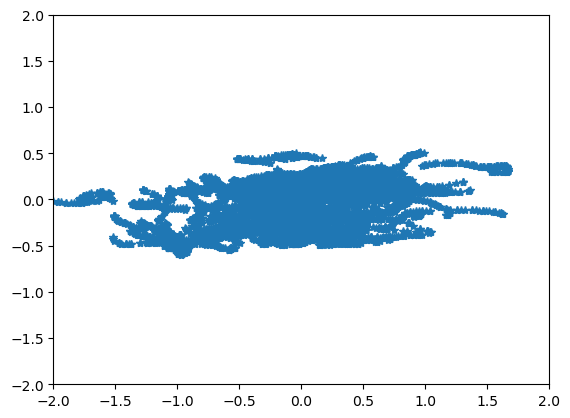

array([[1.       , 0.3372097],
       [0.3372097, 1.       ]])

In [13]:
labels_list = torch.cat(labels_full).cpu()
outputs_list = torch.cat(outputs_full).cpu()

plt.plot(np.array(labels_list),np.array(outputs_list),'*')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()
np.corrcoef(np.array(labels_list).squeeze(),np.array(outputs_list).squeeze())

In [152]:
x = torch.randn(1, 1, np.shape(np_arr_x_train_anom)[1], np.shape(np_arr_x_train_anom)[2], device=device, requires_grad=True)

attnlrp = Composite({
        nn.MultiheadAttention: lm.MultiheadAttention_CP,
        # order matters! lm.LinearInProjection is inside lm.MultiheadAttention_CP
        lm.LinearInProjection: rules.EpsilonRule,
        lm.LinearOutProjection: rules.EpsilonRule,
        transformer.LayerNorm: lm.LayerNormEpsilon,
        nn.GELU: rules.IdentityRule,
        operator.add: lf.add2,
        operator.matmul: lf.matmul,
        F.normalize: lf.normalize,
    })

best_mod.eval()

traced = attnlrp.register(best_mod, dummy_inputs={'x': x}, verbose=True)
traced

conv_gamma = 0.5
lin_gamma = 0.05
zennit_comp = LayerMapComposite([
            (torch.nn.Conv2d, z_rules.Gamma(conv_gamma)),
            (torch.nn.Linear, z_rules.Gamma(lin_gamma)),
        ])
        # register composite
zennit_comp.register(traced)

heatmaps=[]

# forward & backward pass
for input in np_arr_x_val_anom[:300]:
    y = traced(inputs.to(device).requires_grad_(True))
    y = lf.mean(y,dim=0,keep_dim=True)
    # y.backward()
    # normalize the heatmap
    x.grad = None
    y.backward()
    heatmap = inputs.to(device).grad[0].sum(0)
    heatmap = heatmap / abs(heatmap).max()
    heatmaps.append(heatmap.cpu().numpy())


# zennit composites can be removed so that we can register a new one!
zennit_comp.remove()

+-----------------------------------------------------------+--------------------------------------------------------+------------+------------------+
| Parent Module                                             | Function                                               | Replaced   | LRP compatible   |
+===========================================================+========================================================+============+==================+
| <class 'torch.nn.modules.conv.Conv2d'>                    | -                                                      | -          |  ⁇               |
+-----------------------------------------------------------+--------------------------------------------------------+------------+------------------+
| <class 'torch.nn.modules.linear.Identity'>                | -                                                      | -          |  ⁇               |
+-----------------------------------------------------------+---------------------------------

In [136]:
# heatmaps

In [153]:
meanheatmaps = np.mean(heatmaps,axis=0)

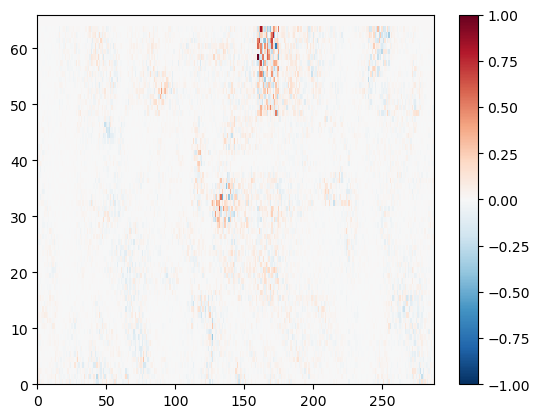

In [157]:
plt.pcolor(meanheatmaps,cmap='RdBu_r',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

## Train with old model

In [72]:
batch_size = 64
input_shape = (1, 1, 192, 288) # Example input shape (C, H, W)


#(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):

model = svitl.VisionTransformer(
        image_lr = 192,
        image_ud = 288,
        patch_size = 16,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 3,
        depth = 2,
        num_heads = 3,
        mlp_ratio = 2.,
    ).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_dataset = SpatialDataset(np_arr_x_train_anom, np_arr_y_train_anom )
val_dataset = SpatialDataset(np_arr_x_val_anom, np_arr_y_val_anom)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 30000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    labels_full = []
    outputs_full = []
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            labels_full.append(labels)
            outputs_full.append(outputs)
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(np_arr_y_val_anom[:, ilat, ilon]))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.5255
MSE: 0.53760
r2: -0.08711743354797363
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.4542
MSE: 0.50767
r2: -0.026589155197143555
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.4181
MSE: 0.49536
r2: -0.0016968250274658203
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.3966
MSE: 0.47612
r2: 0.037208497524261475
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.3767
MSE: 0.46715
r2: 0.05533987283706665
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.3621
MSE: 0.45665
r2: 0.07657957077026367
...saving!...
Starting Epoch 6
Epoch 6, Loss: 0.3528
MSE: 0.45493
r2: 0.08004790544509888
...saving!...
Starting Epoch 7
Epoch 7, Loss: 0.3420
MSE: 0.46729
r2: 0.05506628751754761
No improvement in validation accuracy.
Starting Epoch 8
Epoch 8, Loss: 0.3367
MSE: 0.46446
r2: 0.06079202890396118
No improvement in validation accuracy.
Starting Epoch 9
Epoch 9, Loss: 0.3299
MSE: 0.45482
r2: 0.08028846979141235
...saving!...
Starting Epoch 10
Epoch 10, Loss:

In [43]:
labels_list = torch.cat(labels_full).cpu()
outputs_list = torch.cat(outputs_full).cpu()

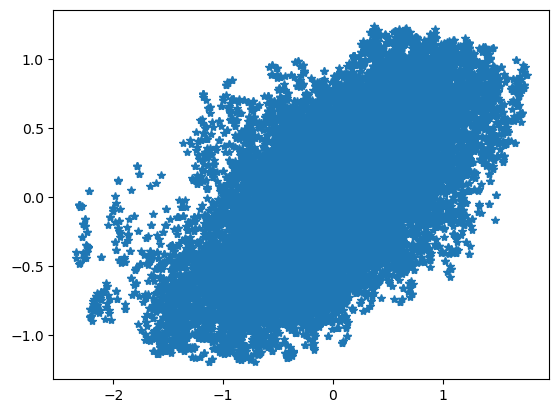

array([[1.        , 0.64742232],
       [0.64742232, 1.        ]])

In [59]:
plt.plot(np.array(labels_list),np.array(outputs_list),'*')
plt.show()
np.corrcoef(np.array(labels_list).squeeze(),np.array(outputs_list).squeeze())

In [ ]:
labels = labels.to(device)
outputs = model(inputs.to(device))

In [28]:
outputs.shape

torch.Size([20, 1])

In [85]:
Xval_check = torch.nan_to_num(torch.tensor(np_arr_x_val_anom, dtype=torch.float32)).unsqueeze(0)
Xval_check_flipped = Xval_check.transpose(0,1)
print('...predicting...')
with torch.no_grad():
    pred = model(Xval_check_flipped[-7000:].to(device))
    true = torch.tensor(np_arr_y_val_anom[-7000:, ilat, ilon], dtype=torch.float32)
    pred = pred.squeeze()
    true = true.squeeze()

mse = np.mean((pred.cpu().detach().numpy() - true.cpu().detach().numpy())**2)
print(mse) # this looks reasonable...
r2 = 1 - (mse/np.var(true.cpu().detach().numpy()))
print(r2) # WHY IS THIS NEGATIVE?? Should be close to 0.36

corr = np.corrcoef(pred.cpu().detach().numpy(),true.cpu().detach().numpy())
print(corr)

...predicting...
0.27825418
0.3047060966491699
[[1.         0.58094623]
 [0.58094623 1.        ]]


array([[1.        , 0.58094623],
       [0.58094623, 1.        ]])

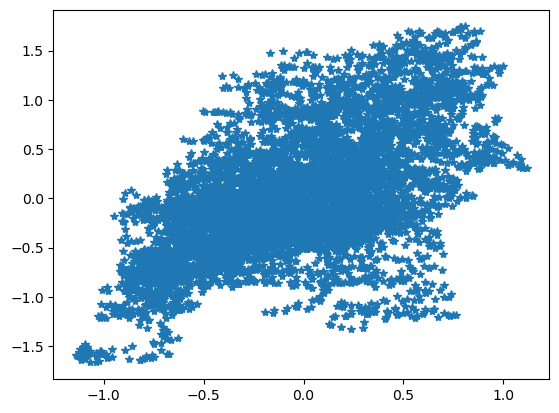

In [86]:
plt.plot(np.array(pred.cpu()),np.array(true.cpu()),'*')
np.corrcoef(np.array(pred.cpu()).squeeze(),np.array(true.cpu()).squeeze())

In [88]:
# trying Tony idea to fit a linear model
true_std = (true.cpu().detach().numpy() - np.mean(true.cpu().detach().numpy(),axis=0))/np.std(true.cpu().detach().numpy(),axis=0)
pred_std = (pred.cpu().detach().numpy() - np.mean(pred.cpu().detach().numpy(),axis=0))/np.std(pred.cpu().detach().numpy(),axis=0)

pred_linear = 0.58094623*pred_std*np.std(true.cpu().detach().numpy(),axis=0) + np.mean(true.cpu().detach().numpy(),axis=0)
1-(np.mean((pred_linear - true.cpu().detach().numpy())**2)/np.var(true.cpu().detach().numpy()))

0.33749860525131226

In [89]:
# plt.plot(Yval_check.cpu().detach().numpy())
# plt.plot(Xval_outputs.cpu().detach().numpy())
# plt.show()

# plt.plot(Xval_outputs.cpu().detach().numpy(),Yval_check.cpu().detach().numpy(),linewidth=0,marker='.')
# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
# plt.show()

In [90]:
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')


...setting up dask client...
...shutdown client...


In [25]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()